In [1]:
# import sys
# sys.executable

In [2]:
import random
import copy
import os
import shutil
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, models
from efficientnet_pytorch import EfficientNet

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

from PIL import Image

import matplotlib.pyplot as plt
from tqdm import tqdm

# random states
RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed(RANDOM_STATE)
torch.backends.cudnn.deterministic = True

%matplotlib inline

# Load data

In [3]:
DATA_PATH = './data'  # must contain folders for each class, in each folder - images for that class
classes = os.listdir(DATA_PATH)
print(f'Data path "{DATA_PATH}" contains:\n{classes} classes')
print(f"Number of classes: {len(classes)}")

Data path "./data" contains:
['cleaned', 'dirty'] classes
Number of classes: 2


In [4]:
# def check_valid(path):
#     with open(path, 'rb') as f:
#         tt = f.read()
#     return len(tt) > 0

In [5]:
def check_valid(path):
    try:
        Image.open(path)
        return True
    except:
        return False

In [6]:
data = {'path': [], 'class': []}
for class_ in classes:
    class_path = os.path.join(DATA_PATH, class_)

    for file in os.listdir(class_path):
        full_path = os.path.join(class_path, file)

        if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.png'):

            if check_valid(full_path):
                data['path'].append(file)
                data['class'].append(class_)

            else:
                print(f"File {full_path} is not included, corrupted image")

        else:
            print(f"File {full_path} is not included, not an image")

data = pd.DataFrame(data)
print('='*50)
print(f'Collected data with shape: {data.shape}, with columns: {data.columns.tolist()}')
print('='*50)
print(data.sample(5))

File ./data\cleaned\.DS_Store is not included, not an image
File ./data\dirty\.DS_Store is not included, not an image
Collected data with shape: (40, 2), with columns: ['path', 'class']
        path    class
19  0019.jpg  cleaned
16  0016.jpg  cleaned
15  0015.jpg  cleaned
26  0006.jpg    dirty
4   0004.jpg  cleaned


# Train|test splits

In [7]:
# with stratification
SPLIT_TEST = True
train_images, val_images, train_classes, val_classes = train_test_split(
    data['path'], data['class'], test_size=0.2, random_state=RANDOM_STATE, stratify=data['class']
)

if SPLIT_TEST:
    train_images, test_images, train_classes, test_classes = train_test_split(
        train_images, train_classes, test_size=0.2, random_state=RANDOM_STATE, stratify=train_classes
    )

train = pd.concat((train_images, train_classes), axis=1)
val = pd.concat((val_images, val_classes), axis=1)
test = pd.concat((test_images, test_classes), axis=1)

In [8]:
train.shape, val.shape, test.shape

((25, 2), (8, 2), (7, 2))

# Create temp directory for images

In [9]:
TEMP_ROOT = './temp'
if not os.path.exists(TEMP_ROOT):
    os.mkdir(TEMP_ROOT)
    os.mkdir(os.path.join(TEMP_ROOT, 'train'))
    os.mkdir(os.path.join(TEMP_ROOT, 'val'))
    if SPLIT_TEST:
        os.mkdir(os.path.join(TEMP_ROOT, 'test'))

    for class_ in classes:
        os.mkdir(os.path.join(TEMP_ROOT, f'train/{class_}'))
        os.mkdir(os.path.join(TEMP_ROOT, f'val/{class_}'))
        if SPLIT_TEST:
            os.mkdir(os.path.join(TEMP_ROOT, f'test/{class_}'))
    print('Temporary directory created')

else:
    print('Temporary directory exists')

Temporary directory created


# Copy files to temporary directory

In [10]:
train.head()

,path,class
12,0012.jpg,cleaned
11,0011.jpg,cleaned
39,0019.jpg,dirty
32,0012.jpg,dirty
35,0015.jpg,dirty


In [11]:
%%time
COPY_FILES = True  # set to false if copied

split_datas = [train, val, test] if SPLIT_TEST else [train, val]
split_names = ['train', 'val', 'test'] if SPLIT_TEST else ['train', 'val']

if COPY_FILES:
    for set_, split in zip(split_datas, split_names):
        path_to_split = os.path.join(TEMP_ROOT, split)
        for idx, (img_path, class_) in set_.iterrows():
            # where to copy image
            path_to = os.path.join(os.path.join(path_to_split, class_), img_path)
            # from to copy image
            path_from = os.path.join(os.path.join(DATA_PATH, class_), img_path)
            # copy file
            shutil.copy2(path_from, path_to)
    print('Files copied')

Files copied
CPU times: total: 31.2 ms
Wall time: 73.4 ms


# Transforms for images

In [12]:
transforms_train = transforms.Compose({
    transforms.Resize((224, 224)),
    transforms.ColorJitter(0.5, 0.5, 0.5),
    transforms.ToTensor()
})

transforms_test = transforms.Compose({
    transforms.Resize((224, 224)),
    transforms.ToTensor()
})

# Datasets

In [13]:
train_dataset = torchvision.datasets.ImageFolder(os.path.join(TEMP_ROOT, 'train'), transforms_train)
val_dataset = torchvision.datasets.ImageFolder(os.path.join(TEMP_ROOT, 'val'), transforms_test)
if SPLIT_TEST:
    test_dataset = torchvision.datasets.ImageFolder(os.path.join(TEMP_ROOT, 'test'), transforms_test)

# Quick look

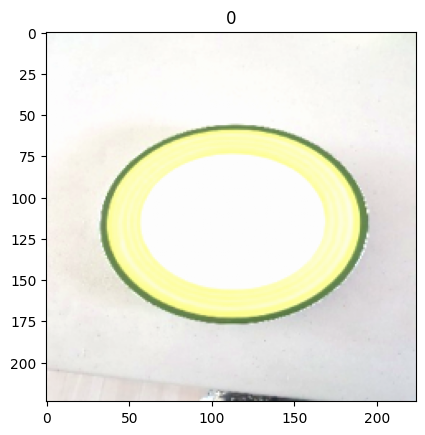

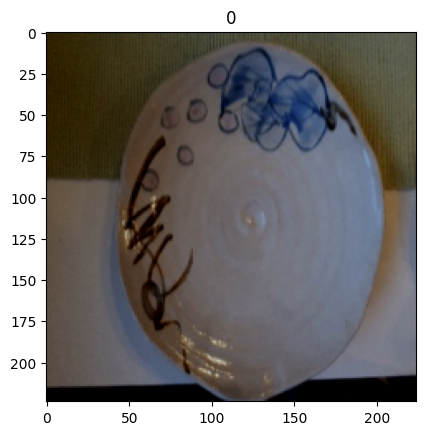

In [14]:
idxs = np.random.choice(range(0, len(train_dataset)), size=2, replace=False)

for idx in idxs:
    image, class_ = train_dataset[idx]
    plt.title(class_)
    image = image.numpy().transpose(1, 2, 0)
    plt.imshow(image)
    plt.pause(0.1)

In [15]:
print(train_dataset.class_to_idx)

{'cleaned': 0, 'dirty': 1}


# Image embeddings

In [16]:
class EfficientNetEmbeddings(nn.Module):
    def __init__(self, model_name='efficientnet-b0', weights_path=None):
        super().__init__()
        self.model = EfficientNet.from_pretrained(
            model_name=model_name,
            weights_path=weights_path,
            advprop=True,
            include_top=False
        ).eval()

    @torch.no_grad()
    def forward(self, x):
        out = self.model(x)
        return out

In [17]:
effnet_embs = EfficientNetEmbeddings(weights_path='./models/adv-efficientnet-b0-b64d5a18.pth')

Loaded pretrained weights for efficientnet-b0


# Dataloaders

In [18]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, num_workers=4)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, num_workers=4)
if SPLIT_TEST:
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, num_workers=4)

# Get Image Features from EfficientNet

In [19]:
train_x = []
train_y = []
N_COPIES = 5  # copy the train set N times to apply different transforms for augmentation

print('Creating features for train set')
for i in range(N_COPIES):
    for batch_x, batch_y in tqdm(train_dataloader):
        embs = effnet_embs(batch_x)
        batch_size, n_features, _, _ = embs.shape
        
        train_x.extend(embs.view(batch_size, n_features).detach().tolist())
        train_y.extend(batch_y.tolist())

train_x = np.array(train_x)
train_y = np.array(train_y)

val_x = []
val_y = []

print('Creating features for val set')
for batch_x, batch_y in tqdm(val_dataloader):
    embs = effnet_embs(batch_x)
    batch_size, n_features, _, _ = embs.shape
    
    val_x.extend(embs.view(batch_size, n_features).detach().tolist())
    val_y.extend(batch_y.tolist())

val_x = np.array(val_x)
val_y = np.array(val_y)

if SPLIT_TEST:
    test_x = []
    test_y = []
    
    print('Creating features for test set')
    for batch_x, batch_y in tqdm(test_dataloader):
        embs = effnet_embs(batch_x)
        batch_size, n_features, _, _ = embs.shape
        
        test_x.extend(embs.view(batch_size, n_features).detach().tolist())
        test_y.extend(batch_y.tolist())

    test_x = np.array(test_x)
    test_y = np.array(test_y)

Creating features for train set


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.91s/it]


Creating features for val set


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.21s/it]


Creating features for test set


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.13s/it]


# Delete temp, datasets, dataloaders

In [20]:
del train_dataset, train_dataloader
del val_dataset, val_dataloader
if SPLIT_TEST:
    del test_dataset, test_dataloader

shutil.rmtree(TEMP_ROOT)

# Modeling

In [21]:
from sklearn.metrics import classification_report, accuracy_score

In [22]:
from lightgbm import LGBMClassifier

In [23]:
lgm = LGBMClassifier(verbose=-1)  # default params
lgm.fit(train_x, train_y, eval_set=(val_x, val_y))

LGBMClassifier(verbose=-1)

In [24]:
pred_train = lgm.predict(train_x)
pred_val = lgm.predict(val_x)

print("TRAIN"+"="*50)
print(classification_report(train_y, pred_train))
print("VAL"+"="*50)
print(classification_report(val_y, pred_val))

TRAIN==================================================
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00        65

    accuracy                           1.00       125
   macro avg       1.00      1.00      1.00       125
weighted avg       1.00      1.00      1.00       125

VAL==================================================
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.50      0.67         4

    accuracy                           0.75         8
   macro avg       0.83      0.75      0.73         8
weighted avg       0.83      0.75      0.73         8



# Optimizing lightgbm

In [25]:
import optuna

D:\Dev\jupyter\projects\Data Science\venvs\image_venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
from sklearn.model_selection import cross_val_score

In [27]:
def objective_lgm(trial):
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }

    m = LGBMClassifier(**param)
    # m.fit(train_x, train_y, eval_set=(val_x, val_y))
    # preds = m.predict(val_x)
    # acc = accuracy_score(val_y, preds)
    acc = cross_val_score(m, train_x, train_y, cv=5).mean()
    return acc


study_lgm = optuna.create_study(direction='maximize')
study_lgm.optimize(objective_lgm, n_trials=100)

[I 2024-04-03 15:53:56,587] A new study created in memory with name: no-name-26080ada-e0bd-4319-8c72-7d2a5217a355
[I 2024-04-03 15:53:56,668] Trial 0 finished with value: 0.52 and parameters: {'lambda_l1': 0.0003609743428983506, 'lambda_l2': 1.1181189040671263e-08, 'num_leaves': 195, 'feature_fraction': 0.76230576146129, 'bagging_fraction': 0.928188834082425, 'bagging_freq': 1, 'min_child_samples': 72}. Best is trial 0 with value: 0.52.
[I 2024-04-03 15:53:56,755] Trial 1 finished with value: 0.52 and parameters: {'lambda_l1': 0.024543860660013742, 'lambda_l2': 0.8310976303810642, 'num_leaves': 187, 'feature_fraction': 0.9486709846139663, 'bagging_fraction': 0.797070507975623, 'bagging_freq': 6, 'min_child_samples': 78}. Best is trial 0 with value: 0.52.
[I 2024-04-03 15:53:56,830] Trial 2 finished with value: 0.52 and parameters: {'lambda_l1': 5.456328822985578e-06, 'lambda_l2': 1.3159067202466608e-05, 'num_leaves': 235, 'feature_fraction': 0.5518970559479506, 'bagging_fraction': 0.81

In [28]:
study_lgm.best_params

{'lambda_l1': 0.012521032310029242,
 'lambda_l2': 0.00021069622874432065,
 'num_leaves': 83,
 'feature_fraction': 0.5546004038058181,
 'bagging_fraction': 0.84364760178957,
 'bagging_freq': 5,
 'min_child_samples': 23}

In [29]:
lgm = LGBMClassifier(**study_lgm.best_params, verbose=-1)
lgm.fit(train_x, train_y, eval_set=(val_x, val_y))

LGBMClassifier(bagging_fraction=0.84364760178957, bagging_freq=5,
               feature_fraction=0.5546004038058181,
               lambda_l1=0.012521032310029242, lambda_l2=0.00021069622874432065,
               min_child_samples=23, num_leaves=83, verbose=-1)

In [30]:
pred_train = lgm.predict(train_x)
pred_val = lgm.predict(val_x)

print("TRAIN"+"="*50)
print(classification_report(train_y, pred_train))
print("VAL"+"="*50)
print(classification_report(val_y, pred_val))

TRAIN==================================================
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00        65

    accuracy                           1.00       125
   macro avg       1.00      1.00      1.00       125
weighted avg       1.00      1.00      1.00       125

VAL==================================================
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.75      0.86         4

    accuracy                           0.88         8
   macro avg       0.90      0.88      0.87         8
weighted avg       0.90      0.88      0.87         8



# Modeling catboost

In [31]:
from catboost import CatBoostClassifier

In [32]:
cat = CatBoostClassifier(verbose=10)  # default params
cat.fit(train_x, train_y, eval_set=(val_x, val_y))

Learning rate set to 0.01896
0:	learn: 0.6730239	test: 0.6912370	best: 0.6912370 (0)	total: 187ms	remaining: 3m 6s
10:	learn: 0.5087402	test: 0.6196464	best: 0.6196464 (10)	total: 578ms	remaining: 51.9s
20:	learn: 0.3942346	test: 0.5930593	best: 0.5930593 (20)	total: 960ms	remaining: 44.7s
30:	learn: 0.3082180	test: 0.5667686	best: 0.5667686 (30)	total: 1.36s	remaining: 42.7s
40:	learn: 0.2403943	test: 0.5363115	best: 0.5363115 (40)	total: 1.74s	remaining: 40.7s
50:	learn: 0.1926492	test: 0.4980153	best: 0.4980153 (50)	total: 2.13s	remaining: 39.7s
60:	learn: 0.1605757	test: 0.4833017	best: 0.4833017 (60)	total: 2.52s	remaining: 38.8s
70:	learn: 0.1347994	test: 0.4640893	best: 0.4634996 (69)	total: 2.92s	remaining: 38.2s
80:	learn: 0.1147820	test: 0.4493254	best: 0.4493254 (80)	total: 3.31s	remaining: 37.5s
90:	learn: 0.0975083	test: 0.4457721	best: 0.4455335 (88)	total: 3.7s	remaining: 37s
100:	learn: 0.0836889	test: 0.4292055	best: 0.4292055 (100)	total: 4.11s	remaining: 36.6s
110:	l

In [33]:
pred_train = cat.predict(train_x)
pred_val = cat.predict(val_x)

print("TRAIN"+"="*50)
print(classification_report(train_y, pred_train))
print("VAL"+"="*50)
print(classification_report(val_y, pred_val))

TRAIN==================================================
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00        65

    accuracy                           1.00       125
   macro avg       1.00      1.00      1.00       125
weighted avg       1.00      1.00      1.00       125

VAL==================================================
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         4

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8



# Modeling linear

In [34]:
from sklearn.linear_model import SGDClassifier

In [35]:
sgd = SGDClassifier(loss='log_loss')  # almost default
sgd.fit(train_x, train_y)

SGDClassifier(loss='log_loss')

In [36]:
pred_train = sgd.predict(train_x)
pred_val = sgd.predict(val_x)

print("TRAIN"+"="*50)
print(classification_report(train_y, pred_train))
print("VAL"+"="*50)
print(classification_report(val_y, pred_val))

TRAIN==================================================
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00        65

    accuracy                           1.00       125
   macro avg       1.00      1.00      1.00       125
weighted avg       1.00      1.00      1.00       125

VAL==================================================
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.75      0.86         4

    accuracy                           0.88         8
   macro avg       0.90      0.88      0.87         8
weighted avg       0.90      0.88      0.87         8



# Optimizing linear

In [37]:
def objective_sgd(trial):
    param = {
        # 'loss': trial.suggest_categorical('loss', ['hinge', 'log_loss']),
        'loss': 'log_loss',
        'penalty': 'l2',
        'alpha': trial.suggest_float('alpha', 1e-8, 10.0, log=True),
        'max_iter': trial.suggest_int('max_iter', 100, 2000),
        'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'optimal', 'invscaling', 'adaptive']),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', None]),
        'eta0': trial.suggest_float('eta0', 1e-8, 10.0, log=True),
        'random_state': RANDOM_STATE
    }

    m = SGDClassifier(**param)
    # m.fit(train_x, train_y, eval_set=(val_x, val_y))
    # preds = m.predict(val_x)
    # acc = accuracy_score(val_y, preds)
    acc = cross_val_score(m, train_x, train_y, cv=5).mean()
    return acc


study_sgd = optuna.create_study(direction='maximize')
study_sgd.optimize(objective_sgd, n_trials=100)

[I 2024-04-03 15:55:17,104] A new study created in memory with name: no-name-34a0df3f-057c-45a9-b35c-ca0a3aa680b5
[I 2024-04-03 15:55:17,237] Trial 0 finished with value: 0.944 and parameters: {'alpha': 0.0004401333300526379, 'max_iter': 1880, 'learning_rate': 'constant', 'class_weight': 'balanced', 'eta0': 1.2326141920421755e-05}. Best is trial 0 with value: 0.944.
[I 2024-04-03 15:55:17,259] Trial 1 finished with value: 0.9199999999999999 and parameters: {'alpha': 0.13011633716801743, 'max_iter': 1453, 'learning_rate': 'constant', 'class_weight': 'balanced', 'eta0': 1.1155794844009232e-06}. Best is trial 0 with value: 0.944.
[I 2024-04-03 15:55:17,283] Trial 2 finished with value: 1.0 and parameters: {'alpha': 5.97700786990054e-06, 'max_iter': 1811, 'learning_rate': 'optimal', 'class_weight': None, 'eta0': 0.0023363384964004727}. Best is trial 2 with value: 1.0.
[I 2024-04-03 15:55:17,303] Trial 3 finished with value: 0.664 and parameters: {'alpha': 1.7471814642828943e-08, 'max_iter'

In [38]:
study_sgd.best_params

{'alpha': 5.97700786990054e-06,
 'max_iter': 1811,
 'learning_rate': 'optimal',
 'class_weight': None,
 'eta0': 0.0023363384964004727}

In [39]:
sgd = SGDClassifier(loss='log_loss', **study_sgd.best_params, random_state=RANDOM_STATE)
sgd.fit(train_x, train_y)

SGDClassifier(alpha=5.97700786990054e-06, eta0=0.0023363384964004727,
              loss='log_loss', max_iter=1811, random_state=42)

In [40]:
pred_train = sgd.predict(train_x)
pred_val = sgd.predict(val_x)

print("TRAIN"+"="*50)
print(classification_report(train_y, pred_train))
print("VAL"+"="*50)
print(classification_report(val_y, pred_val))

TRAIN==================================================
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00        65

    accuracy                           1.00       125
   macro avg       1.00      1.00      1.00       125
weighted avg       1.00      1.00      1.00       125

VAL==================================================
              precision    recall  f1-score   support

           0       0.57      1.00      0.73         4
           1       1.00      0.25      0.40         4

    accuracy                           0.62         8
   macro avg       0.79      0.62      0.56         8
weighted avg       0.79      0.62      0.56         8



# Ensembling

In [41]:
from typing import List

class WeightedModel:
    def __init__(self, fitted_models: List, models_weights: List = None):
        self.fitted_models = fitted_models

        if models_weights is None:
            models_weights = [1/len(fitted_models) for _ in range(len(fitted_models))]

        assert (1 - sum(models_weights)) < 1e-8, 'weights must sum to 1'
        self.models_weights = models_weights

    def __call__(self, x: np.array):
        return self.predict(x)

    def predict_proba(self, x: np.array):
        result = np.zeros([x.shape[0], len(classes)])
        for model, weight in zip(self.fitted_models, self.models_weights):
            pred = model.predict_proba(x)
            result += weight * pred

        return result

    def predict(self, x: np.array):
        probas = self.predict_proba(x)
        return probas.max(axis=-1), probas.argmax(axis=-1)

In [42]:
# from sklearn.ensemble import VotingClassifier

# model = VotingClassifier([("Lightgbm", lgm), ("Catboost", cat), ("Linear", sgd)]).fit(train_x, train_y)

In [43]:
model = WeightedModel(
    fitted_models=[lgm, cat, sgd],
    models_weights=None
)

In [44]:
model.predict(val_x)

(array([0.95323332, 0.91620581, 0.98661451, 0.80508467, 0.5896402 ,
        0.62931354, 0.7250519 , 0.994236  ]),
 array([0, 0, 0, 0, 1, 0, 0, 1], dtype=int64))

In [45]:
val_y

array([0, 0, 0, 0, 1, 1, 1, 1])

# Find optimal weights

In [46]:
from itertools import permutations, combinations_with_replacement
import numpy as np

def find_optimum_weights_for_ensemble(models, data_for_models, y_test, metric, target, is_classification=False):
    assert target in ['minimize', 'maximize']
    
    n_models = len(models.keys())
    preds = {}
    for model_name, model in models.items():
        if is_classification:
            preds[model_name] = model.predict_proba(data_for_models[model_name])
        else:
            preds[model_name] = model.predict(data_for_models[model_name])
        
    coefs_unique = [
        i for i in combinations_with_replacement(np.linspace(0, 1, 11), n_models) if sum(i) == 1
    ]
    
    if target == 'minimize':
        best_metric = np.inf
    else:
        best_metric = -np.inf
    best_coefs = None
    
    for coefs in coefs_unique:
        for variant in set(list(permutations(coefs, n_models))):
            string = ' '.join([f'{list(models.keys())[i]}: {coef}' for i, coef in enumerate(variant)])
            print(string)

            result_predict = np.sum(
                [variant[i] * preds[model_name] for i, model_name in enumerate(preds.keys())],
                axis=0)

            if is_classification:
                result_metric = metric(y_test, result_predict.argmax(-1))
            else:
                result_metric = metric(y_test, result_predict)
            print(f'Metric: {result_metric}')
            
            if target == 'minimize':
                if result_metric < best_metric:
                    best_metric = result_metric
                    best_coefs = variant
            else:
                if result_metric > best_metric:
                    best_metric = result_metric
                    best_coefs = variant
    return best_coefs, best_metric

In [47]:
models = {
    'LGM': lgm,
    'Cat': cat,
    'SGD': sgd
}

data_for_models = {
    'LGM': val_x,
    'Cat': val_x,
    'SGD': val_x
}

find_optimum_weights_for_ensemble(
    models=models,
    data_for_models=data_for_models,
    y_test=val_y,
    metric=accuracy_score,
    target='maximize',
    is_classification=True
)

LGM: 1.0 Cat: 0.0 SGD: 0.0
Metric: 0.875
LGM: 0.0 Cat: 0.0 SGD: 1.0
Metric: 0.625
LGM: 0.0 Cat: 1.0 SGD: 0.0
Metric: 1.0
LGM: 0.0 Cat: 0.1 SGD: 0.9
Metric: 0.625
LGM: 0.0 Cat: 0.9 SGD: 0.1
Metric: 0.875
LGM: 0.9 Cat: 0.0 SGD: 0.1
Metric: 0.875
LGM: 0.9 Cat: 0.1 SGD: 0.0
Metric: 0.875
LGM: 0.1 Cat: 0.9 SGD: 0.0
Metric: 1.0
LGM: 0.1 Cat: 0.0 SGD: 0.9
Metric: 0.625
LGM: 0.8 Cat: 0.0 SGD: 0.2
Metric: 0.75
LGM: 0.0 Cat: 0.8 SGD: 0.2
Metric: 0.75
LGM: 0.0 Cat: 0.2 SGD: 0.8
Metric: 0.625
LGM: 0.2 Cat: 0.8 SGD: 0.0
Metric: 1.0
LGM: 0.2 Cat: 0.0 SGD: 0.8
Metric: 0.625
LGM: 0.8 Cat: 0.2 SGD: 0.0
Metric: 0.875
LGM: 0.30000000000000004 Cat: 0.0 SGD: 0.7000000000000001
Metric: 0.625
LGM: 0.30000000000000004 Cat: 0.7000000000000001 SGD: 0.0
Metric: 0.875
LGM: 0.0 Cat: 0.30000000000000004 SGD: 0.7000000000000001
Metric: 0.625
LGM: 0.7000000000000001 Cat: 0.0 SGD: 0.30000000000000004
Metric: 0.75
LGM: 0.7000000000000001 Cat: 0.30000000000000004 SGD: 0.0
Metric: 0.875
LGM: 0.0 Cat: 0.7000000000000001 S

((0.0, 1.0, 0.0), 1.0)

In [48]:
model = WeightedModel(
    fitted_models=[lgm, cat, sgd],
    models_weights=[0.9, 0.0, 0.1]
)

In [49]:
model.predict(val_x)

(array([0.95961342, 0.96783048, 0.98053089, 0.75085718, 0.79228291,
        0.53531151, 0.78644728, 0.99723427]),
 array([0, 0, 0, 0, 1, 1, 0, 1], dtype=int64))

# Results

In [50]:
_, pred_train = model.predict(train_x)
_, pred_val = model.predict(val_x)
_, pred_test = model.predict(test_x)

print("TRAIN"+"="*50)
print(classification_report(train_y, pred_train))
print("VAL"+"="*50)
print(classification_report(val_y, pred_val))
print("TEST"+"="*50)
print(classification_report(test_y, pred_test))

TRAIN==================================================
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00        65

    accuracy                           1.00       125
   macro avg       1.00      1.00      1.00       125
weighted avg       1.00      1.00      1.00       125

VAL==================================================
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.75      0.86         4

    accuracy                           0.88         8
   macro avg       0.90      0.88      0.87         8
weighted avg       0.90      0.88      0.87         8

TEST==================================================
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.75      1.00      0.86         3

    accuracy     

# Whole Pipeline

In [51]:
import PIL

In [52]:
class ImageClassifier:
    def __init__(self, transforms, feature_extractor, class_predictor, class_mapping):
        self.transforms = transforms
        self.feature_extractor = feature_extractor
        self.class_predictor = class_predictor

        self.class_mapping = class_mapping

    def __call__(self, image: PIL.Image):
        return self.predict(image)

    def predict(self, image: PIL.Image):
        x = self.transforms(image)
        x = x.unsqueeze(0)  # 1 image in batch

        featured_x = self.feature_extractor(x).detach().numpy().reshape(1, -1)
        prob, pred = self.class_predictor(featured_x)
        return prob, self.class_mapping[pred[0]]

In [53]:
class_mapping = {'cleaned': 0, 'dirty': 1}
inv_class_mapping = {j: i for i, j in class_mapping.items()}
inv_class_mapping

{0: 'cleaned', 1: 'dirty'}

In [54]:
image_classifier = ImageClassifier(
    transforms=transforms_test,
    feature_extractor=effnet_embs,
    class_predictor=model,
    class_mapping=inv_class_mapping
)

cleaned


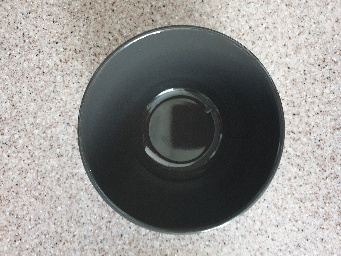

In [55]:
sample = data.sample(1).values[0]  # path
path = os.path.join(DATA_PATH, f"{sample[1]}\{sample[0]}")
print(sample[1])
img = PIL.Image.open(path)
img

In [56]:
image_classifier(img)

(array([0.97513873]), 'cleaned')